In [ ]:
# default_exp samplers.protocol_samplers

# Protocol Samplers

> Collection of different samplers for sampling logical failure rates from quantum error correction protocols

In [ ]:
# hide
from nbdev.showdoc import *

In [ ]:
#export
import qsam.math as math
from qsam.circuit import partition, make_hash, unpack
from qsam.fault_generators import Depolar
from qsam.protocol import iterate
from qsam.samplers.common import *

import numpy as np
from tqdm.notebook import tqdm

In [ ]:
#export

class Sampler:
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        self.is_setup = False
        
    def setup(self, sample_range, err_params):
        self.partitions = {circuit_hash: [partition(circuit, GATE_GROUPS[k]) for k in err_params.keys()]
                           for circuit_hash, circuit in self.protocol._circuits.items()}
        self.p_phys = [s * np.array(list(err_params.values())) for s in sample_range]
        self.fail_cnts = np.zeros(len(sample_range))
        self.cnts = np.zeros(len(sample_range))
        self.store = {}
        self.is_setup = True
        
    def stats(self, p_idx=None, var_fn=math.Wilson_var, **kwargs):
        if p_idx == None:
            rate = self.fail_cnts / self.cnts
            var = var_fn(rate, self.cnts)
        else:
            rate = self.fail_cnts[p_idx] / self.cnts[p_idx]
            var = var_fn(rate, self.cnts[p_idx])
            
        return rate, np.sqrt(var), 0.0
    
    def run(self, n_samples, after_cbs=[], inner_cbs=[], outer_cbs=[]):
        assert self.is_setup, 'Sampler not setup. Call setup(..) before run(..).'
        outputs = {}
                
        for i, p_phy in enumerate(tqdm(self.p_phys, desc='Total')):            
            for _ in tqdm(range(n_samples), desc=f'p_phy={",".join(list(f"{p:.2E}" for p in p_phy))}', leave=True):

                sim = self.simulator(self.n_qubits)
                p_it = iterate(self.protocol)
                node = next(p_it)
                self.cnts[i] += 1
                
                while node:
                    
                    if not self.protocol.out_edges(node):
                        self.fail_cnts[i] += 1
                        break
                    
                    circuit_hash, circuit = self.protocol.circuit_from_node(node)
                    if not circuit._noisy or circuit_hash not in self.partitions.keys():
                        msmt = sim.run(circuit)
                    else:
                        circuit_partitions = self.partitions[circuit_hash]
                        faults = Depolar.faults_from_probs(circuit_partitions, p_phy)
                        fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                        msmt = sim.run(circuit, fault_circuit)
                    _node = node
                    node = p_it.send(msmt)
                    
                    for cb in inner_cbs: # inner
                        outputs[cb.__name__] = cb(**locals(), run=True)

                for cb in outer_cbs: # outer
                    outputs[cb.__name__] = cb(sampler=self, p_idx=i, run=True, **outputs)
                if StopIteration in outputs.values(): break
                
        for cb in after_cbs: # after
            outputs[cb.__name__] = cb(sampler=self, run=True, **outputs)
        return outputs

We are going to test the direct Monte Carlo sampler on the simple GHZ state preparation flag circuit. 

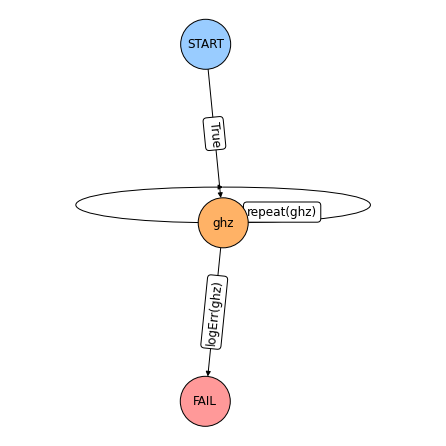

In [ ]:
from qsam.protocol import Protocol, draw_protocol
from qsam.circuit import Circuit

ghz = Circuit([ {"init": {0,1,2,3,4}},
                {"H": {0}},
                {"CNOT": {(0,1)}},
                {"CNOT": {(1,2)}},
                {"CNOT": {(2,3)}},
                {"CNOT": {(3,4)}},
                {"CNOT": {(0,4)}},
                {"measure": {4}}   ], ff_det=True)


def repeat(m):
    return len(m) < 3 and m[-1] == 1
    
def logErr(m):
    return len(m) >= 3 and m[-1] == 1 and m[-2] == 1 and m[-3] == 1

functions = {'logErr': logErr, 'repeat': repeat}

g = Protocol()
g._check_fns.update(functions)
g.add_nodes_from(['ghz'], circuits=[ghz])

g.add_edge('START', 'ghz', check='True')

g.add_edge('ghz', 'ghz', check='repeat(ghz)')
g.add_edge('ghz', 'FAIL', check='logErr(ghz)')

draw_protocol(g, figsize=(6,6))

Total:   0%|          | 0/5 [00:00<?, ?it/s]

p_phy=1.00E-03:   0%|          | 0/300 [00:00<?, ?it/s]

p_phy=5.62E-03:   0%|          | 0/300 [00:00<?, ?it/s]

p_phy=3.16E-02:   0%|          | 0/300 [00:00<?, ?it/s]

p_phy=1.78E-01:   0%|          | 0/300 [00:00<?, ?it/s]

p_phy=1.00E+00:   0%|          | 0/300 [00:00<?, ?it/s]

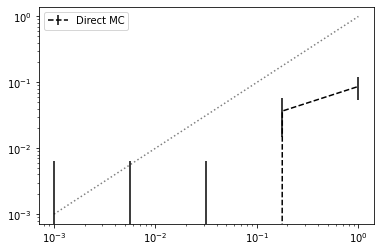

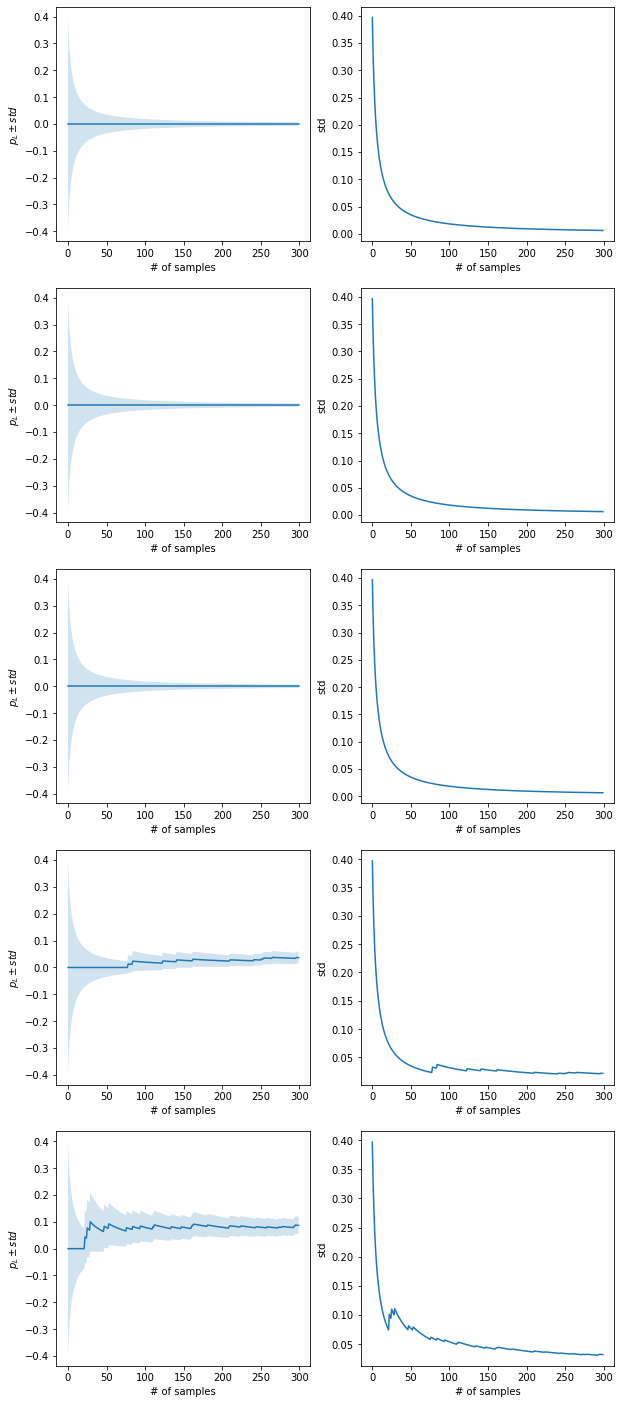

In [ ]:
#slow

from qsam.simulators.chp import ChpSimulator

sample_range = np.logspace(-3,0,5)
err_params = {'p': 1}

sam = Sampler(g, ChpSimulator)
sam.setup(sample_range, err_params)
outputs = sam.run(n_samples=300,  
                  outer_cbs=[stats, rel_std_target, store('stats')],
                  after_cbs=[stats, plot_stats(sample_range), plot_stored_stats(n_splits=5)])

In [ ]:
show_doc(Sampler)

<h2 id="Sampler" class="doc_header"><code>class</code> <code>Sampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>Sampler</code>(**`protocol`**, **`simulator`**)



For the `SubsetSampler` we want to sample from specific fault-weight-subsets upto a certain maximum weight $w_{max}$. The benefit of this approach is that we can scale each of the resulting failure rates by analytically calculated `subset_occurances` for each `p_phy` which then gives us `p_L(p_phy)` for all `p_phy` without any additional sampling required. The subset sampler chooses the next fault-weight subset that is used when sampling from the next circuit in the protocol by the minimum sampled subset for a given circuit, which results in a balanced sampling over all subsets for a circuit. Additionally, one can exclude sampling for all circuits in a protocol from certain subsets by specifying a *list of ints* of `w_exclude` fault-weights. Overall, this approach of choosing the subsets and defining the weight threshold is not ideal. The dynamic subset sampler includes methods to improve on both of these points.

In [ ]:
#export

class SubsetSampler:
    """Subset Sampler of quantum protocols"""
    
    def __init__(self, protocol, simulator):
        self.protocol = protocol
        self.simulator = simulator
        self.n_qubits = len(set(q for c in protocol._circuits.values() for q in unpack(c)))
        self.tree = SampleTree()
        self.is_setup = False
        
    def setup(self, sample_range, err_params, p_max):
        p_max = np.array([p_max]) if isinstance(p_max, float) else np.array(p_max)
        assert len(p_max) == len(err_params)
        self.err_params = err_params
        self.partitions = protocol_partitions(self.protocol._circuits, err_params.keys())
        self.w_vecs = protocol_weight_vectors(self.partitions)
        self.Aws_pmax = protocol_subset_occurence(self.partitions, self.w_vecs, p_max)
        self.store = dict()
        self.set_range(sample_range)
        self.is_setup = True
        
    def set_range(self, sample_range):
        p_phy_per_partition = np.array([[p_phy * mul for p_phy in sample_range] for mul in self.err_params.values()]).T
        self.Aws = protocol_subset_occurence(self.partitions, self.w_vecs, p_phy_per_partition)
        
    def stats(self, const='Aws', **kwargs):
        if const == 'Aws': Aws = self.Aws
        elif const == 'Aws_pmax': Aws = self.Aws_pmax
        v_L = self.tree.var(Aws)
        p_L = self.tree.rate(Aws)
        if isinstance(v_L, np.ndarray) and isinstance(p_L, int): 
            p_L = np.zeros_like(v_L)
        delta = self.tree.delta(Aws)
        return p_L, np.sqrt(v_L), delta
        
    def run(self, n_samples, inner_cbs=[], outer_cbs=[], after_cbs=[], ss_filter_fn=w_plus1_filter, ss_sel_fn=ERV_sel):
        assert self.is_setup, 'Sampler not setup. Call setup(..) before run(..).'
        outputs = {}
        
        for i in tqdm(range(n_samples), desc='Total'):
            sim = self.simulator(self.n_qubits)
            p_it = iterate(self.protocol)
            node = next(p_it)
            tree_node = None
            
            while True:
                tree_node = self.tree.update(name=node, parent=tree_node)
                if node == None: break
                elif not self.protocol.out_edges(node): tree_node.is_fail = True; break
                
                circuit_hash, circuit = self.protocol.circuit_from_node(node)
                if circuit_hash not in self.partitions.keys() or not circuit._noisy: # correction circuits
                    msmt = sim.run(circuit)
                else:
                    w_ids = [n.ckey[1] for n in tree_node.children]
                    w_ids = ss_filter_fn(sampler=self, **locals())
                    w_idx = ss_sel_fn(sampler=self, **locals())
                    w_vec = self.w_vecs[circuit_hash][w_idx]
                    tree_node = self.tree.update(name=w_vec, parent=tree_node, ckey=(circuit_hash, w_idx),
                                                is_deterministic=True if circuit._ff_deterministic and not any(w_vec) else False)

                    faults = Depolar.faults_from_weights(self.partitions[circuit_hash], w_vec)
                    fault_circuit = Depolar.gen_circuit(len(circuit), faults)
                    msmt = sim.run(circuit, fault_circuit)
                
                _node = node
                node = p_it.send(msmt)
            
                for cb in inner_cbs: # inner
                    outputs[cb.__name__] = cb(sampler=self, run=True, **locals())

            for cb in outer_cbs: # outer
                outputs[cb.__name__] = cb(sampler=self, run=True, **outputs)
            if StopIteration in outputs.values(): break
                        
        for cb in after_cbs: # after
            outputs[cb.__name__] = cb(sampler=self, run=True, **outputs)
        return outputs

Total:   0%|          | 0/300 [00:00<?, ?it/s]

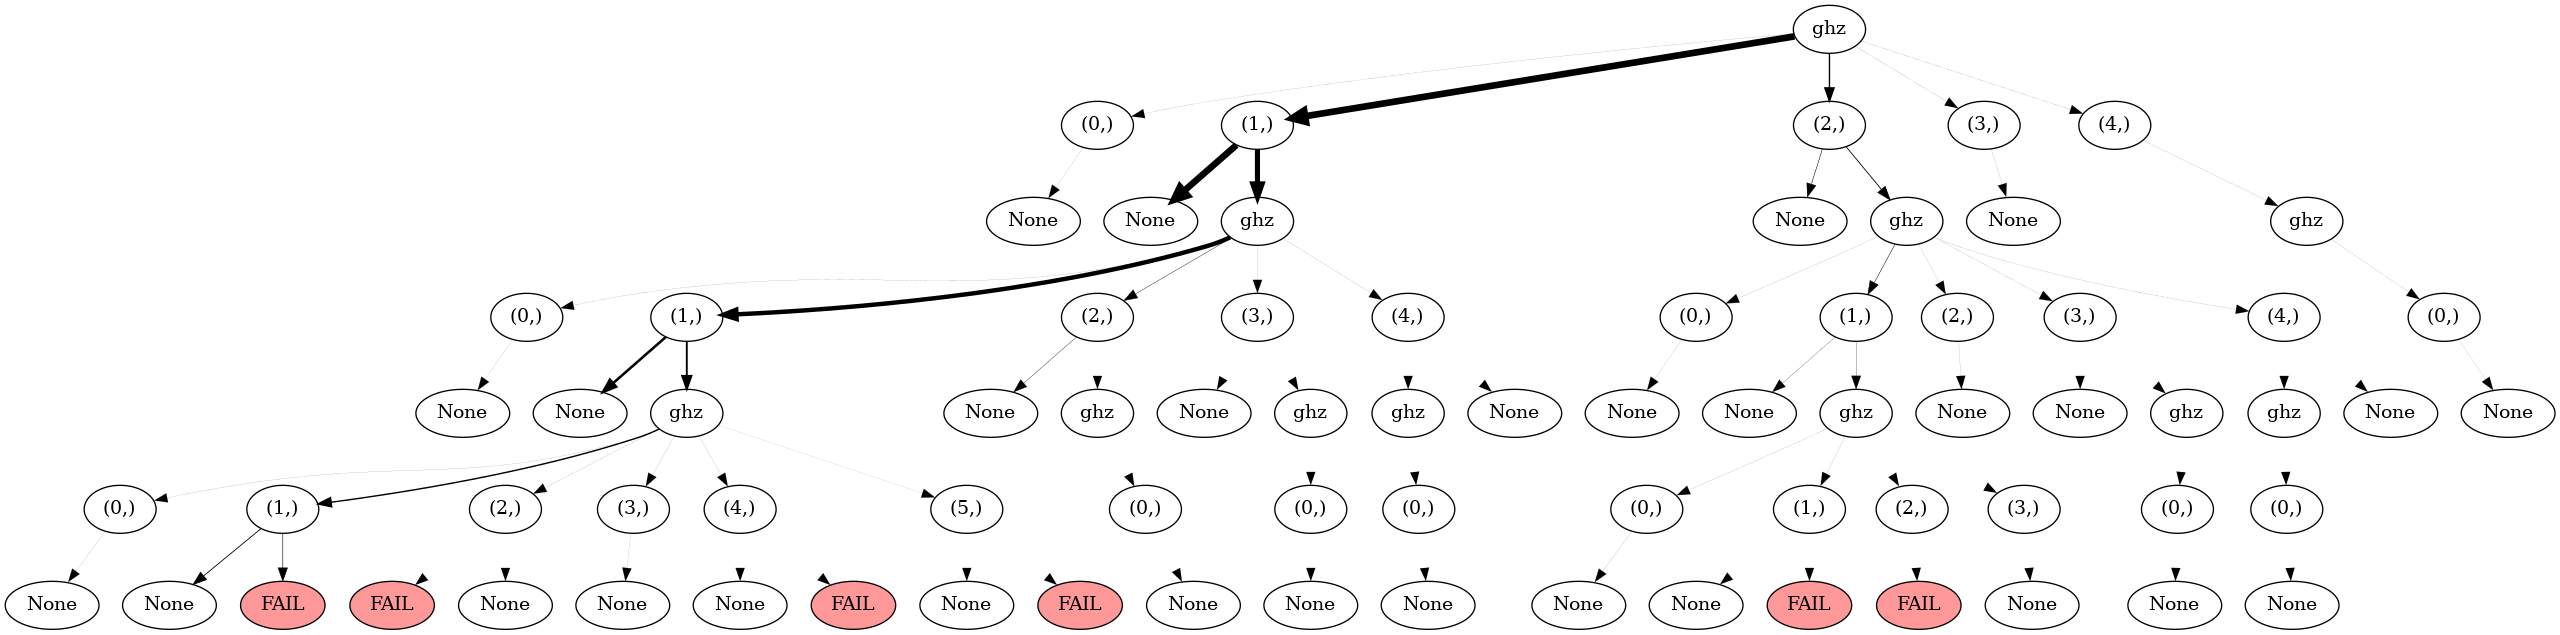

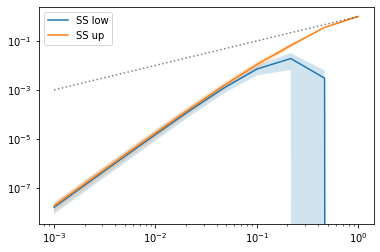

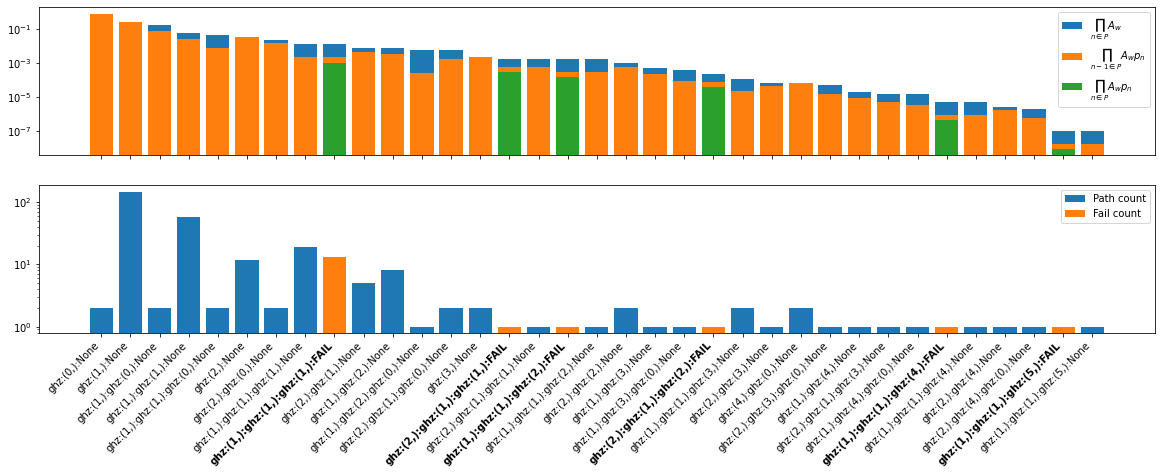

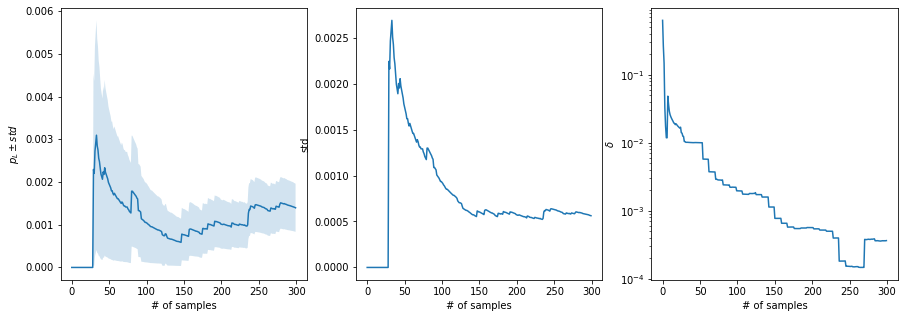

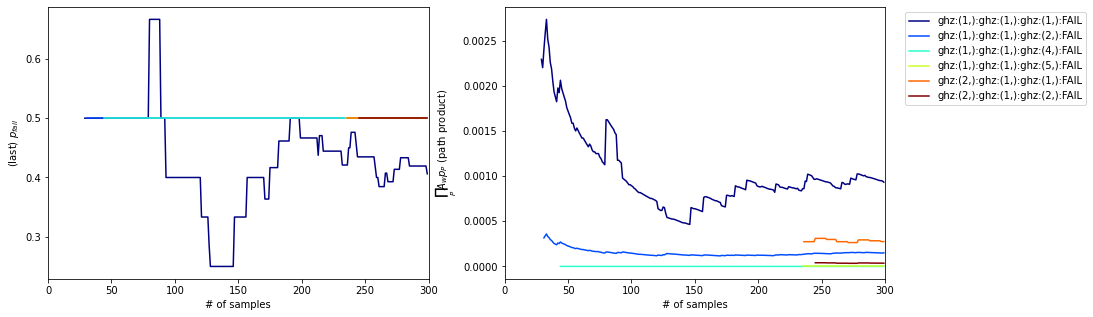

In [ ]:
from qsam.simulators.chp import ChpSimulator as CHP

sample_range = np.logspace(-3,0,10)
err_params = {'p': 1}

sam = SubsetSampler(g, CHP)
sam.setup(sample_range, err_params, p_max=0.05)
outputs = sam.run(300, outer_cbs=[stats(const='Aws_pmax'), subset_rates(fail_only=True), store(fn_names=['stats','subset_rates']), rel_std_target],
                        after_cbs=[stats, 
                                   plot_stats(sample_range=sample_range), 
                                   path_stats, 
                                   plot_path_stats, 
                                   plot_stored_stats(plot_delta=False),
                                   plot_save_tree,
                                   plot_subset_rates
                                  ])#, ss_sel_fn=random_sel)
# outputs = sam.run(1000, outer_cbs=[subset_rates, store('subset_rates')], after_cbs=[plot_subset_rates])

In [ ]:
show_doc(SubsetSampler)

<h2 id="SubsetSampler" class="doc_header"><code>class</code> <code>SubsetSampler</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SubsetSampler</code>(**`protocol`**, **`simulator`**) :: [`SubsetAnalytics`](/qsam/samplers.sampler_mixins.html#SubsetAnalytics)

Subset Sampler of quantum protocols

**Documentation & plots missing...**